<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/main/drgreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about Dr Green machine learning model for plant classification. We will use this model to build a mobile app which can give you the scientific name, local name, common name and therapeutic vertues.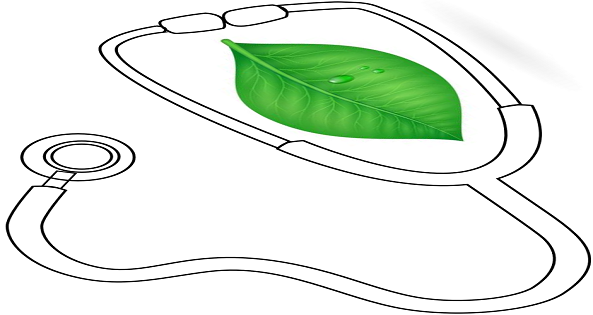

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import numpy as np
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
import zipfile

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

In [2]:
print(tf.__version__)

2.12.0



**DATA PROCESSING**

In [6]:
# Path to download dataset
local_zip = 'plantes.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('plantes')
zip_ref.close()

# Define the datasate path
base_dir = 'plantes/rename/'


In [7]:
# Directory with our training artemisia pictures
train_art_dir = os.path.join('plantes/rename/artemisia')

# Directory with our training carica pictures
train_cari_dir = os.path.join('plantes/rename/carica')
# Directory with our training goyavier pictures
train_goya_dir = os.path.join('plantes/rename/goyavier')
# Directory with our training kinkeliba pictures
train_kink_dir = os.path.join('plantes/rename/kinkeliba')

In [8]:
train_art_names = os.listdir(train_art_dir)
print(train_art_names[:10])
train_cari_names = os.listdir(train_cari_dir)
print(train_cari_names[:10])
train_goya_names = os.listdir(train_goya_dir)
print(train_goya_names[:10])
train_kink_names = os.listdir(train_kink_dir)
print(train_kink_names[:10])

['arte_237.jpg', 'arte_4.jpg', 'arte_39.jpg', 'arte_131.jpg', 'arte_254.JPG', 'arte_260.jpg', 'arte_248.jpg', 'arte_12.jpg', 'arte_146.jpg', 'arte_158.jpg']
['224.figue-commune-ficus-carica-figues-organique.jpg', 'car_48.JPG', '334.figuier-precoce-de-dalmatie-ficus-carica.jpg', '309.figuier-ficus-carica-w.jpg', '526.figuier-144610.jpg', '146.carica_papaya_02.jpg', '299.0427932001291191591.jpg', '131.6_Figuier.jpg', '297.carica_papaya_05.jpg', '308.Carica-papaya-Fleur-male.jpg']
['210.figuier-114841.jpg', '189.2019-01-06_jardin_de_cuisine.jpg', '256.plante-mystere-visoflora-118329.jpg', '573.psidium_friedrichsthalianum1md023512.jpg', '538.goyavier_01.JPG', '503.img_000058120CRS.jpg', '565.papayer-carica-pentagona-babaco.jpg', '425.psidium_guajava5md184802.jpg', '397.depositphotos_319603640-stock-photo.jpg', '275.feuille_manguier_2-72169.jpg']
['266.ob_ec0255_aloe.jpg', '165.gaiac-182157-650-325.jpg', '221.b8d456a2780533319a4f9a12ccab4aa1.jpg', '98.IMGP0279.JPG', '58.kinkeliba-300x300.jp

In [9]:
print('total training artemisia images:', len(os.listdir(train_art_dir)))
print('total training carica images:', len(os.listdir(train_cari_dir)))
print('total training goyavier images:', len(os.listdir(train_goya_dir)))
print('total training kinkeliba images:', len(os.listdir(train_kink_dir)))

total training artemisia images: 250
total training carica images: 357
total training goyavier images: 218
total training kinkeliba images: 293


In [10]:
# Parameters for the loader
batch_size = 32
img_height = 300
img_width = 300

In [11]:
# Split the dataset in training & validation set
train_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="training",
  validation_split=0.4,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="validation",
  validation_split=0.4 ,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1115 files belonging to 4 classes.
Using 669 files for training.
Found 1115 files belonging to 4 classes.
Using 446 files for validation.


In [12]:
# Find the class names using class_names attribut
class_names = train_pl.class_names
print(class_names)

['artemisia', 'carica', 'goyavier', 'kinkeliba']


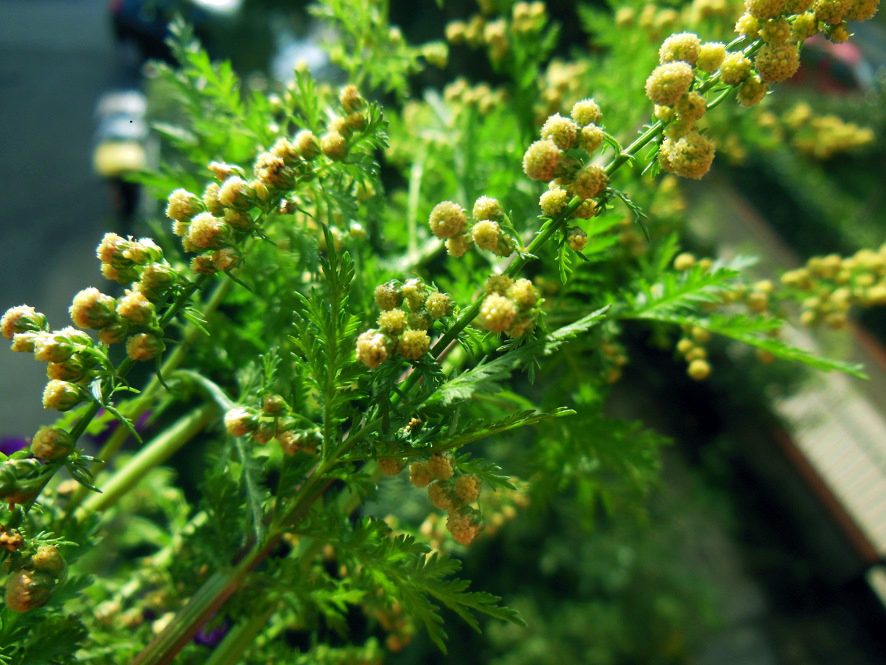

In [13]:
# Show any artemisia image
artemisia = list(glob.glob(base_dir + 'artemisia/*'))
PIL.Image.open(str(artemisia[1]))

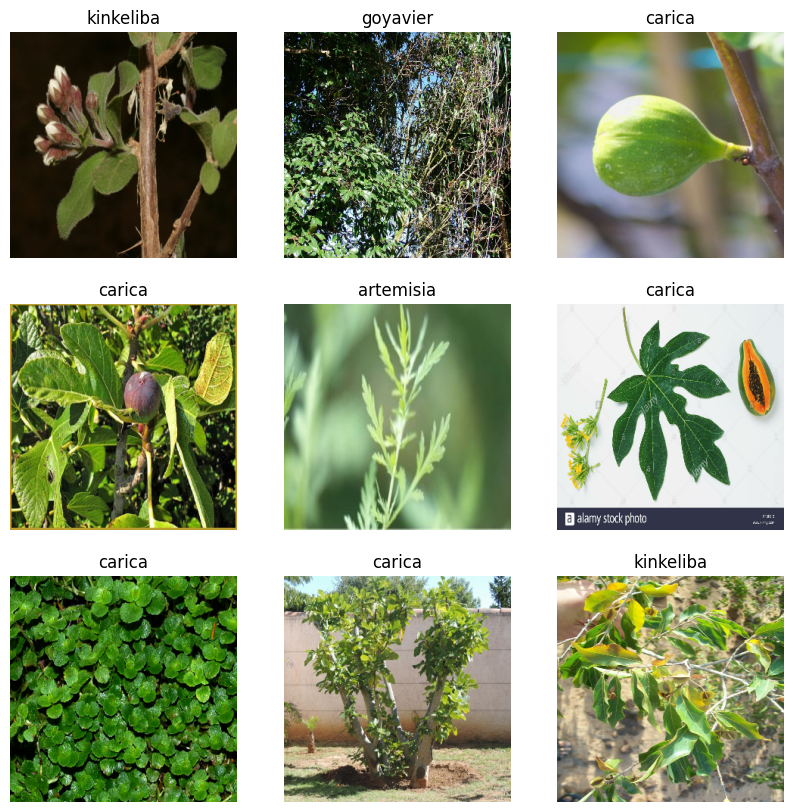

In [14]:
# Visualize the data. Here you will see the first nine images from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_pl.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
# Count the total number of image in the dataset
image_count = len(list(glob.glob(base_dir + '*/*')))

print(image_count)

1118


In [16]:
# Iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_pl:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [17]:
# Overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_pl = train_pl.cache().prefetch(buffer_size=AUTOTUNE)
val_pl = val_pl.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# Standardize Data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_pl.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [21]:
num_classes = 4

model = tf.keras.models.Sequential([
    data_augmentation,
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fouth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The sixth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [22]:
# Show model parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)       

In [23]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              #optimizer='adam',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [24]:
# Add early stopping to the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
# Training model
epochs = 50
history = model.fit(
      train_pl,
      validation_data=val_pl,
      epochs=epochs,
      callbacks=[early_stopping]
      )

Epoch 1/50
21/21 [==============================] - 108s 5s/step - loss: 9.6220 - acc: 0.2676 - val_loss: 5.6380 - val_acc: 0.3229
Epoch 2/50
21/21 [==============================] - 93s 5s/step - loss: 5.4074 - acc: 0.3064 - val_loss: 5.1378 - val_acc: 0.3879
Epoch 3/50
21/21 [==============================] - 97s 5s/step - loss: 4.9675 - acc: 0.3408 - val_loss: 4.7729 - val_acc: 0.3632
Epoch 4/50
21/21 [==============================] - 98s 5s/step - loss: 4.6737 - acc: 0.3408 - val_loss: 4.5695 - val_acc: 0.2668
Epoch 5/50
21/21 [==============================] - 102s 5s/step - loss: 4.4270 - acc: 0.3498 - val_loss: 4.2718 - val_acc: 0.4350
Epoch 6/50
21/21 [==============================] - 89s 4s/step - loss: 4.1983 - acc: 0.3782 - val_loss: 4.0617 - val_acc: 0.4215
Epoch 7/50
21/21 [==============================] - 88s 4s/step - loss: 4.0400 - acc: 0.3647 - val_loss: 3.9361 - val_acc: 0.3901
Epoch 8/50
21/21 [==============================] - 85s 4s/step - loss: 3.9072 - acc: 0.

Build a sequential model with Keras API.

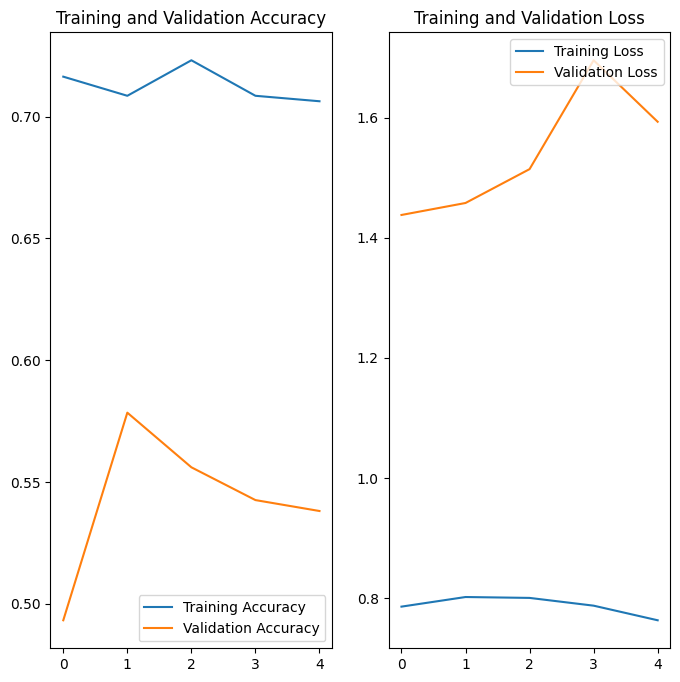

In [31]:
# Visualize training results
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test our model with another image unseen in training and validation set
import numpy as np

from google.colab import files
from keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img= load_img(path, target_size=(180, 180))

  x=img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  plantes = model.predict(images, batch_size=32)

  print(plantes[0])

  if plantes.any():
    print(fn + "is an artemisia")

  else:
    print(fn + "is a carica")


Saving djéka.jpg to djéka.jpg


ValueError: ignored

In [ ]:
# Convert and save model in TensorFlow Lite
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('drgreen.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Download model
from google.colab import files

files.download('drgreen.tflite')
files.download('plants.txt')